### 라이브러리 install

In [19]:
!pip3 install pandas numpy scikit-learn tqdm catboost optuna ipywidgets

### 라이브러리 import

In [20]:
import pandas as pd
import sklearn
import numpy as np
import random
import os
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
)
import optuna
from optuna.samplers import TPESampler
from optuna.pruners import SuccessiveHalvingPruner
from catboost import CatBoostClassifier, Pool

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import RobustScaler,StandardScaler
from sklearn.model_selection import StratifiedKFold

In [21]:
import pandas as pd
import numpy as np
import os
import random

### seed 고정

In [22]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
seed=42
seed_everything(seed) # Seed 고정

### 데이터 불러오기

In [26]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [27]:
df_train.isna().sum()

bant_submit                    0
expected_budget            35177
customer_country             982
business_unit                  0
com_reg_ver_win_rate       44731
customer_idx                   0
lead_date                      0
customer_type              43961
customer_history               0
enterprise                     0
historical_existing_cnt    45543
id_strategic_ver           55855
it_strategic_ver           58178
idit_strategic_ver         54734
customer_job               18733
lead_from_channel           3295
lead_description           30203
lead_desc_length               0
event_name                  1132
inquiry_type                 941
prefer_ver_count           40882
prefer_ver_mean            40882
product_category           19374
product_subcategory        50064
product_modelname          50070
customer_country.1           982
customer_position              0
response_corporate             0
expected_timeline          30863
transfer_agreement           530
ver_cus   

### 전처리(Data leakage 없음)

In [28]:
def category_all(df_train, df_test):
    label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    #new
    "lead_from_channel",
    "lead_description",
    "is_lead_description",
#     "lead_date_year",
#     "lead_date_quarter",
#     "lead_date_year",
#     "lead_date_dayofyear",
#     "lead_date_month",
#     "lead_date_dayofweek",
#     "lead_date_day",
    "event_name",
    "transfer_agreement",
    "expected_budget",
    "customer_country",
    "ver_win_rate_mean_upper",
    "customer_history",
        'bant_submit_cate'
    ]

    for i in label_columns:
        df_train[i] = df_train[i].astype('category')
        df_test[i] = df_test[i].astype('category')
    return df_train, df_test    


def preprocessing(df_train, df_test):
    df_train.drop_duplicates(keep='first', inplace=True)
    df_train.reset_index(inplace=True)
    df_train.drop('index',inplace=True, axis=1)
    df_test_id_temp = df_test['id'].copy()
    df_all = pd.concat([df_train,df_test.drop('id',axis=1)])
    df_all.drop('customer_country.1',axis=1,inplace=True)
    df_all.id_strategic_ver.fillna(0., inplace=True)
    df_all.it_strategic_ver.fillna(0., inplace=True)
    df_all.idit_strategic_ver.fillna(0., inplace=True)
    df_all.business_subarea.fillna('NAN', inplace=True)
    df_all.com_reg_ver_win_rate.fillna(0,inplace=True)
    df_all['customer_type'] = df_all['customer_type'].replace({
        'End-Customer':'End Customer'
    })
    df_all.customer_type.fillna('NAN',inplace=True)
    df_all.historical_existing_cnt.fillna(0, inplace=True)
    
    df_all.product_subcategory.fillna('NAN', inplace=True)
    
    df_all.product_modelname.fillna('NAN', inplace=True)

    df_all['expected_timeline'] = df_all['expected_timeline'].replace({
        'less_than_3_months': 'less than 3 months',
        'being followed up': 'being followed up.',
        'less than 6 months': '3 months ~ 6 months',
        '3_months_~_6_months' : '3 months ~ 6 months'
    })

    df_all.expected_timeline.fillna('NAN',inplace=True)
    df_all.ver_win_rate_x.fillna(0,inplace=True)
    df_all.ver_win_ratio_per_bu.fillna(0,inplace=True)
    df_all.business_area.fillna('NAN',inplace=True)
    df_all.customer_job.fillna('NAN', inplace=True)
    df_all.product_category.fillna('NAN', inplace=True)
    df_all['bant_submit_cate'] = df_all['bant_submit']*4
    df_all['bant_submit_cate'] = df_all['bant_submit_cate'].astype('int64')
    
    ####new Feature
    df_all.lead_from_channel.fillna('NAN',inplace=True)
    df_all['is_lead_description'] = np.where(df_all['lead_description'].isna()==True,0,1)
    df_all['len_lead_description'] = np.where(df_all['lead_description'].isna()==False, df_all['lead_description'].apply(str).apply(len).astype('object'),0)
    df_all.lead_description.fillna('NAN',inplace=True)
#     df_all['lead_date_quarter'] = pd.to_datetime(df_all['lead_date']).dt.quarter
#     df_all['lead_date_year'] = pd.to_datetime(df_all['lead_date']).dt.year
#     df_all['lead_date_dayofyear'] = pd.to_datetime(df_all['lead_date']).dt.dayofyear
#     df_all['lead_date_month'] = pd.to_datetime(df_all['lead_date']).dt.month
#     df_all['lead_date_dayofweek'] = pd.to_datetime(df_all['lead_date']).dt.dayofweek
#     df_all['lead_date_day'] = pd.to_datetime(df_all['lead_date']).dt.day
    df_all.event_name.fillna("NAN", inplace=True)
    df_all.prefer_ver_count.fillna(0,inplace=True)
    df_all.prefer_ver_mean.fillna(0,inplace=True)
    df_all['transfer_agreement'] = np.where(df_all['transfer_agreement'].isna()==True,'M',df_all['transfer_agreement'])
    df_all.ver_win_rate_mean_upper.fillna(0, inplace=True)
    df_all.expected_budget.fillna('NAN', inplace=True)
    df_all.drop(labels='lead_date',axis=1,inplace=True)
    
    #처리못한부분
    #customer_country
    df_all.customer_country.fillna('NAN', inplace=True)
    #inquiry_type
    df_all.inquiry_type.fillna('NAN', inplace=True)

    label_columns = [
        "customer_country",
        "business_subarea",
        "business_area",
        "business_unit",
        "customer_type",
        "enterprise",
        "customer_job",
        "inquiry_type",
        "product_category",
        "product_subcategory",
        "product_modelname",
        "customer_position",
        "response_corporate",
        "expected_timeline",
        "lead_from_channel",
        #new
        "event_name",
        "lead_description",
        "expected_budget",
        "customer_history",

    ]
    
    ###############################
    #detect special char and to lower
    for i in label_columns:
        df_all[i] = df_all[i].str.lower()
        df_all[i] = df_all[i].str.replace(pat=r'[^\w]', repl=r'', regex=True)
        
    #to int
    df_all['id_strategic_ver'] = df_all['id_strategic_ver'].astype('int64')
    df_all['it_strategic_ver'] = df_all['it_strategic_ver'].astype('int64')
    df_all['idit_strategic_ver'] = df_all['idit_strategic_ver'].astype('int64')
    df_all['lead_desc_length'] = df_all['lead_desc_length'].astype('int64')
    df_all['historical_existing_cnt'] = df_all['historical_existing_cnt'].astype('int64')
    df_all['len_lead_description'] = df_all['len_lead_description'].astype('int64')
    
    df_all['ver_win_rate_mean_upper'] = df_all['ver_win_rate_mean_upper'].astype('int64')
    df_all['historical_existing_cnt_log'] = np.log1p(df_all['historical_existing_cnt'])
    df_all['len_lead_description_log'] = np.log1p(df_all['len_lead_description'])
    #seperate
    tmp_len = len(df_train)
    df_train = df_all.iloc[: tmp_len ]
    df_test = df_all.iloc[tmp_len :]
    df_test = pd.concat([df_test,df_test_id_temp],axis=1)
    
    #RobustScaler
    Scaler = StandardScaler()
    df_train['ver_win_rate_x_s'] = Scaler.fit_transform(df_train[['ver_win_rate_x']])
    df_test['ver_win_rate_x_s'] = Scaler.transform(df_test[['ver_win_rate_x']])
    Scaler = StandardScaler()
    df_train['ver_win_ratio_per_bu_s'] = Scaler.fit_transform(df_train[['ver_win_ratio_per_bu']])
    df_test['ver_win_ratio_per_bu_s'] = Scaler.transform(df_test[['ver_win_ratio_per_bu']])
    Scaler = StandardScaler()
    df_train['com_reg_ver_win_rate_s'] = Scaler.fit_transform(df_train[['com_reg_ver_win_rate']])
    df_test['com_reg_ver_win_rate_s'] = Scaler.transform(df_test[['com_reg_ver_win_rate']])
    Scaler = StandardScaler()
    df_train['prefer_ver_mean_s'] = Scaler.fit_transform(df_train[['prefer_ver_mean']])
    df_test['prefer_ver_mean_s'] = Scaler.transform(df_test[['prefer_ver_mean']])
    Scaler = StandardScaler()
    df_train['prefer_ver_count_s'] = Scaler.fit_transform(df_train[['prefer_ver_count']])
    df_test['prefer_ver_count_s'] = Scaler.transform(df_test[['prefer_ver_count']])
    ##############################
    
    return df_train, df_test


df_train, df_test = preprocessing(df_train, df_test)
df_train, df_test = category_all(df_train, df_test)
rate = ((len(df_train)-sum(df_train['is_converted']))/sum(df_train['is_converted']))
x_train, y_train = df_train.drop("is_converted",axis=1), df_train["is_converted"]

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 57065 entries, 0 to 57064
Data columns (total 47 columns):
 #   Column                       Non-Null Count  Dtype   
---  ------                       --------------  -----   
 0   bant_submit                  57065 non-null  float64 
 1   expected_budget              57065 non-null  category
 2   customer_country             57065 non-null  category
 3   business_unit                57065 non-null  category
 4   com_reg_ver_win_rate         57065 non-null  float64 
 5   customer_idx                 57065 non-null  category
 6   customer_type                57065 non-null  category
 7   customer_history             57065 non-null  category
 8   enterprise                   57065 non-null  category
 9   historical_existing_cnt      57065 non-null  int64   
 10  id_strategic_ver             57065 non-null  category
 11  it_strategic_ver             57065 non-null  category
 12  idit_strategic_ver           57065 non-null  category
 13  custom

### stratified K-fold(k = 10)

In [87]:
categorical_features = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    #new
    "lead_from_channel",
        "lead_description",
    "is_lead_description",
#     "lead_date_year",
#     "lead_date_quarter",
#     "lead_date_year",
#     "lead_date_dayofyear",
#     "lead_date_month",
#     "lead_date_dayofweek",
#     "lead_date_day",
    "event_name",
    "transfer_agreement",
    "expected_budget",
    "customer_country",
        "ver_win_rate_mean_upper",
        "customer_history",
    "bant_submit_cate"
    ]

S_kfold = StratifiedKFold(n_splits=4, shuffle=True, random_state=seed)

all_train_pool = []
all_val_pool = []
all_y_val = []

for train_idx, val_idx in S_kfold.split(x_train, list(y_train)):
    tmp_x_train, tmp_x_val = x_train.iloc[train_idx], x_train.iloc[val_idx]
    tmp_y_train, tmp_y_val = y_train[train_idx], y_train[val_idx]
    train_pool = Pool(data=tmp_x_train, label=tmp_y_train, cat_features=categorical_features)
    val_pool = Pool(data=tmp_x_val, label=tmp_y_val, cat_features=categorical_features)
    all_train_pool.append(train_pool)
    all_val_pool.append(val_pool)
    all_y_val.append(list(tmp_y_val))

### optuna를 통한 hyperparameter 튜닝

In [32]:
def objective(trial):
    params = {
        "iterations": 1000,
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0),
        "random_strength": trial.suggest_float("random_strength", 1e-3, 1e-1, log=True),
        "border_count": trial.suggest_int("border_count", 1, 255),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 1e2, log=True),
        "leaf_estimation_iterations": trial.suggest_int("leaf_estimation_iterations", 1, 10),
        "leaf_estimation_method": trial.suggest_categorical("leaf_estimation_method", ["Newton", "Gradient"]),
        "bootstrap_type": trial.suggest_categorical("bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        "one_hot_max_size": trial.suggest_int("one_hot_max_size", 0, 25),
        "random_state": seed,
        "verbose": 0,
    }
    
    #score = []
    tmp_score = []
    for train_pool, val_pool, y_true in zip(all_train_pool, all_val_pool, all_y_val):
        clf = CatBoostClassifier(**params,
                                 scale_pos_weight=np.sqrt(rate), 
                                 loss_function='Logloss',
                                 eval_metric='F1',
                                 early_stopping_rounds=100
                                )
        clf.fit(train_pool, eval_set=val_pool)
        
        y_pred = clf.predict(val_pool)
        y_pred = [False if i=='False' else True for i in y_pred]
        tmp_score.append(f1_score(y_true,y_pred,labels=[True, False]))
    tmp_score = np.mean(tmp_score)
    return tmp_score

# Hyperparameter Tuning
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed), pruner=SuccessiveHalvingPruner())
study.optimize(objective, n_trials=None)

[I 2024-04-06 16:10:55,833] A new study created in memory with name: no-name-046a6298-c6a9-4cca-8945-88f8ab72bb1a
[I 2024-04-06 16:12:42,004] Trial 0 finished with value: 0.7774591632691126 and parameters: {'depth': 6, 'learning_rate': 0.9507635921035062, 'random_strength': 0.029106359131330698, 'border_count': 153, 'l2_leaf_reg': 0.006026889128682512, 'leaf_estimation_iterations': 2, 'leaf_estimation_method': 'Gradient', 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 19, 'one_hot_max_size': 4}. Best is trial 0 with value: 0.7774591632691126.
[I 2024-04-06 16:12:57,167] Trial 1 finished with value: 0.7578185364606413 and parameters: {'depth': 6, 'learning_rate': 0.5252316752006057, 'random_strength': 0.007309539835912915, 'border_count': 75, 'l2_leaf_reg': 1.1462107403425035, 'leaf_estimation_iterations': 2, 'leaf_estimation_method': 'Gradient', 'bootstrap_type': 'Bernoulli', 'grow_policy': 'Depthwise', 'min_data_in_leaf': 61, 'one_hot_max_size': 4}.

[I 2024-04-06 16:32:20,129] Trial 18 finished with value: 0.7611424236830613 and parameters: {'depth': 6, 'learning_rate': 0.6725350127162361, 'random_strength': 0.026317100026730753, 'border_count': 250, 'l2_leaf_reg': 0.39275971610008614, 'leaf_estimation_iterations': 4, 'leaf_estimation_method': 'Gradient', 'bootstrap_type': 'Bayesian', 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 64, 'one_hot_max_size': 21}. Best is trial 0 with value: 0.7774591632691126.
[I 2024-04-06 16:32:38,799] Trial 19 finished with value: 0.7563186231383541 and parameters: {'depth': 5, 'learning_rate': 0.8787310792142676, 'random_strength': 0.05676076056081949, 'border_count': 109, 'l2_leaf_reg': 0.10248142107096443, 'leaf_estimation_iterations': 3, 'leaf_estimation_method': 'Gradient', 'bootstrap_type': 'MVS', 'grow_policy': 'Lossguide', 'min_data_in_leaf': 64, 'one_hot_max_size': 25}. Best is trial 0 with value: 0.7774591632691126.
[I 2024-04-06 16:34:52,139] Trial 20 finished with value: 0.78045110

[I 2024-04-06 17:11:40,845] Trial 36 finished with value: 0.7870978855374903 and parameters: {'depth': 9, 'learning_rate': 0.08078286932467549, 'random_strength': 0.003268186862206943, 'border_count': 45, 'l2_leaf_reg': 9.69070264875675, 'leaf_estimation_iterations': 9, 'leaf_estimation_method': 'Gradient', 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 29, 'one_hot_max_size': 25}. Best is trial 36 with value: 0.7870978855374903.
[I 2024-04-06 17:13:58,112] Trial 37 finished with value: 0.7625162984064416 and parameters: {'depth': 10, 'learning_rate': 0.07713454318091345, 'random_strength': 0.0023278529943443005, 'border_count': 38, 'l2_leaf_reg': 31.997753373238037, 'leaf_estimation_iterations': 10, 'leaf_estimation_method': 'Newton', 'bootstrap_type': 'Bernoulli', 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 29, 'one_hot_max_size': 25}. Best is trial 36 with value: 0.7870978855374903.
[I 2024-04-06 17:14:17,237] Trial 38 finished with value:

[I 2024-04-06 17:46:37,994] Trial 54 finished with value: 0.7665230525138679 and parameters: {'depth': 9, 'learning_rate': 0.758196541942212, 'random_strength': 0.0020442666984575204, 'border_count': 35, 'l2_leaf_reg': 36.730041845391455, 'leaf_estimation_iterations': 8, 'leaf_estimation_method': 'Gradient', 'bootstrap_type': 'Bayesian', 'grow_policy': 'Lossguide', 'min_data_in_leaf': 62, 'one_hot_max_size': 12}. Best is trial 36 with value: 0.7870978855374903.
[I 2024-04-06 17:48:14,906] Trial 55 finished with value: 0.7559678512790313 and parameters: {'depth': 10, 'learning_rate': 0.9986887834939554, 'random_strength': 0.0013133391345940273, 'border_count': 182, 'l2_leaf_reg': 68.8189698320301, 'leaf_estimation_iterations': 7, 'leaf_estimation_method': 'Newton', 'bootstrap_type': 'MVS', 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 14, 'one_hot_max_size': 2}. Best is trial 36 with value: 0.7870978855374903.
[I 2024-04-06 17:49:54,551] Trial 56 finished with value: 0.76099172731

[I 2024-04-06 18:21:26,774] Trial 72 finished with value: 0.7714590276796728 and parameters: {'depth': 10, 'learning_rate': 0.21575072785503238, 'random_strength': 0.01677694318182144, 'border_count': 130, 'l2_leaf_reg': 24.249393251095977, 'leaf_estimation_iterations': 3, 'leaf_estimation_method': 'Newton', 'bootstrap_type': 'Bayesian', 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 31, 'one_hot_max_size': 2}. Best is trial 36 with value: 0.7870978855374903.
[I 2024-04-06 18:22:55,302] Trial 73 finished with value: 0.757844416076499 and parameters: {'depth': 9, 'learning_rate': 0.5431887352780381, 'random_strength': 0.02809172256257776, 'border_count': 144, 'l2_leaf_reg': 43.393847815507556, 'leaf_estimation_iterations': 6, 'leaf_estimation_method': 'Newton', 'bootstrap_type': 'Bayesian', 'grow_policy': 'SymmetricTree', 'min_data_in_leaf': 38, 'one_hot_max_size': 23}. Best is trial 36 with value: 0.7870978855374903.
[I 2024-04-06 18:23:22,775] Trial 74 finished with value: 0.7649

KeyboardInterrupt: 

In [99]:
param = study.best_params
param['one_hot_max_size'] = 2

### Train Catboost Classifier(cpu)

In [100]:
best_models=[]
for train_pool, val_pool in zip(all_train_pool, all_val_pool):
    best_model = CatBoostClassifier(**param,
                                random_state=seed,
                                scale_pos_weight=np.sqrt(rate), 
                                loss_function='Logloss',
                                eval_metric='F1',
                                verbose=100,
                                early_stopping_rounds=100,)
    best_model.fit(train_pool, eval_set=val_pool)
    best_models.append(best_model)

0:	learn: 0.7559152	test: 0.7722009	best: 0.7722009 (0)	total: 60.4ms	remaining: 1m
100:	learn: 0.9145608	test: 0.9033069	best: 0.9043963 (80)	total: 8.7s	remaining: 1m 17s
200:	learn: 0.9362856	test: 0.9025524	best: 0.9045238 (118)	total: 17.9s	remaining: 1m 11s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.9045237657
bestIteration = 118

Shrink model to first 119 iterations.
0:	learn: 0.7584780	test: 0.7737240	best: 0.7737240 (0)	total: 50.8ms	remaining: 50.7s
100:	learn: 0.9155767	test: 0.9022164	best: 0.9030924 (80)	total: 8.4s	remaining: 1m 14s
200:	learn: 0.9360310	test: 0.9054453	best: 0.9058138 (197)	total: 17.7s	remaining: 1m 10s
300:	learn: 0.9515886	test: 0.9030650	best: 0.9072609 (220)	total: 27s	remaining: 1m 2s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 0.907260864
bestIteration = 220

Shrink model to first 221 iterations.
0:	learn: 0.7586936	test: 0.7629415	best: 0.7629415 (0)	total: 52.3ms	remaining: 52.2s
100:	learn: 0.914

### test

In [83]:
categorical_features = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_position",
    "response_corporate",
    "expected_timeline",
   'customer_idx',
   'lead_owner',
    'id_strategic_ver',
    'it_strategic_ver',
    'idit_strategic_ver',
    'ver_cus',
    'ver_pro',
    #new
    "lead_from_channel",
        "lead_description",
    "is_lead_description",
#     "lead_date_year",
#     "lead_date_quarter",
#     "lead_date_year",
#     "lead_date_dayofyear",
#     "lead_date_month",
#     "lead_date_dayofweek",
#     "lead_date_day",
    "event_name",
    "transfer_agreement",
    "expected_budget",
    "customer_country",
        "ver_win_rate_mean_upper",
        "customer_history",
    'bant_submit_cate'
    ]
# 
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)
test_pool = Pool(data=x_test, cat_features=categorical_features)


### predict(soft voting)

In [101]:
# 예측 수행 (soft voting)
pred = [best_model.predict_proba(test_pool) for best_model in best_models]
pred = np.mean(pred, axis=0)
cpu_pred = np.argmax(pred, axis=1)


In [102]:
sum(cpu_pred)

1687

In [51]:
from tqdm.notebook import tqdm

In [91]:
big=0
big_num=0
for i in tqdm(np.arange(0.5,0.9,0.01)):
    tmp_score=[]
    for val_pool, y_true,best_model in zip(all_val_pool, all_y_val, best_models):
        y_pred = best_model.predict_proba(val_pool)
        y_pred = np.where(y_pred[:,1]>i,True,False)
        tmp_score.append(f1_score(y_true,y_pred,labels=[True, False]))
    tmp_score = np.mean(tmp_score)
    if big < tmp_score:
        big = tmp_score
        big_num=i
print(big)

  0%|          | 0/40 [00:00<?, ?it/s]

0.8523474609714453


In [92]:
print(big_num)

0.6700000000000002


### optuna를 통한 hyperparameter 튜닝

In [ ]:
# def objective(trial):
#     params = {
#         'iterations':trial.suggest_int("iterations", 10000, 50000),
#         'learning_rate' : trial.suggest_uniform('learning_rate',0.001, 1),
#         'reg_lambda': trial.suggest_uniform('reg_lambda',10,100),
#         'random_strength': trial.suggest_uniform('random_strength',40,100),
#         'min_data_in_leaf': trial.suggest_int('min_data_in_leaf',1,50),
#         'leaf_estimation_iterations': trial.suggest_int('leaf_estimation_iterations',1,15),
#         'bagging_temperature' :trial.suggest_uniform('bagging_temperature', 0, 1),
#         'verbose':False,
#         'random_state':seed,
#     }
    
#     #score = []
#     tmp_score = []
#     for train_pool, val_pool, y_true in zip(all_train_pool, all_val_pool, all_y_val):
#         clf = CatBoostClassifier(**params,
#                                  scale_pos_weight=rate, 
#                                  loss_function='Logloss',
#                                  eval_metric='F1',
#                                  task_type="GPU",
#                                  early_stopping_rounds=100
#                                 )
#         clf.fit(train_pool, eval_set=val_pool)
        
#         y_pred = clf.predict(val_pool)
#         y_pred = [False if i=='False' else True for i in y_pred]
#         tmp_score.append(f1_score(y_true,y_pred,labels=[True, False]))
#     tmp_score = np.mean(tmp_score)
#     return tmp_score

# # Hyperparameter Tuning
# study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=seed), pruner=SuccessiveHalvingPruner())
# study.optimize(objective, n_trials=None)

### parameter(GPU)

In [11]:
best_param = {'iterations': 22865,
 'learning_rate': 0.4558039595854515,
 'reg_lambda': 40.615274454632356,
 'random_strength': 69.76295482198546,
 'min_data_in_leaf': 18,
 'leaf_estimation_iterations': 13,
 'bagging_temperature': 0.06021831198300387}

### train Catboost Classifier(GPU)
파일 위치를 제대로 지정해 주시거나 GPU가 있어야 합니다.   
leader board점수를 완벽히 복원하려면 파일을 불러와야 합니다.

In [16]:
best_models = []
try:
    print('모델을 불러오는 중')
    for i in range(10):
        best_models.append(CatBoostClassifier().load_model(f'model_{i}.cbm', format='cbm'))
except:
    best_models = []
    try:
        print('모델을 불러오는 중 오류가 발생해 모델 학습 중입니다.')
        for train_pool, val_pool in zip(all_train_pool, all_val_pool):
            best_model = CatBoostClassifier(**best_param,
                                        random_state=seed,
                                        scale_pos_weight=rate, 
                                        loss_function='Logloss',
                                        eval_metric='F1',
                                        task_type="GPU",
                                        verbose=100,
                                        early_stopping_rounds=100)
        best_model.fit(train_pool, eval_set=val_pool)
        best_models.append(best_model)
    except:
        print('파일 위치를 제대로 지정해 주시거나 GPU가 있어야 합니다.\nleader board점수를 완벽히 복원하려면 파일을 불러와야 합니다.')

모델을 불러오는 중


### predict(soft voting)

In [13]:
# 예측 수행 (soft voting)
pred = [best_model.predict_proba(test_pool) for best_model in best_models]
pred = np.mean(pred, axis=0)
gpu_pred = np.argmax(pred, axis=1)

### hard voting(cpu pred + gpu pred)

In [14]:
hard_pred = [True if (cpu_pred[i] or gpu_pred[i]) else False for i in range(len(cpu_pred))]   

In [103]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = cpu_pred

# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

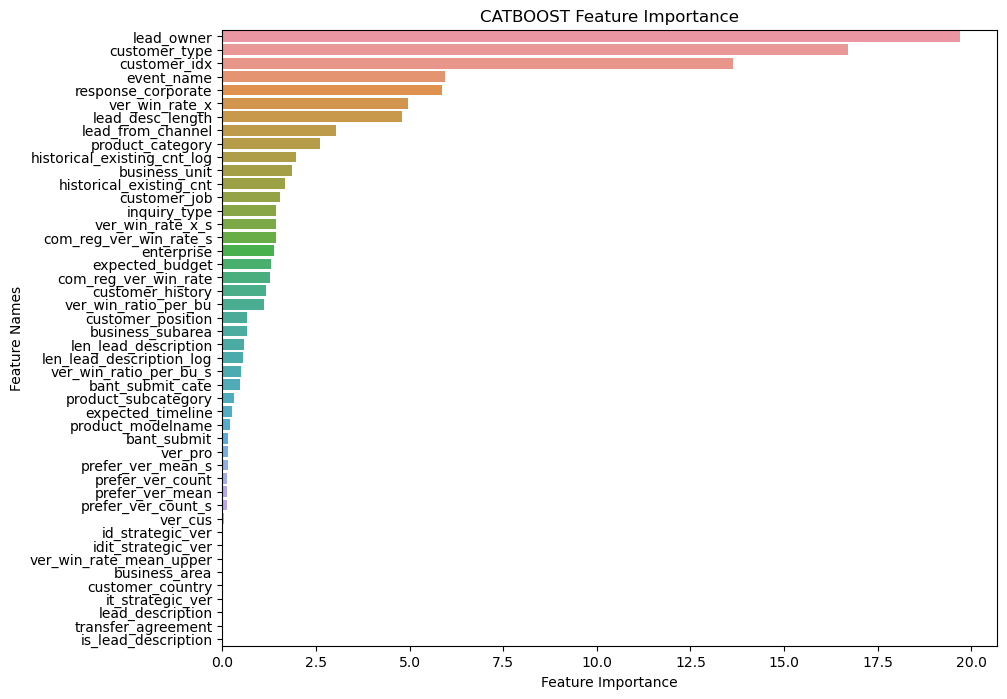

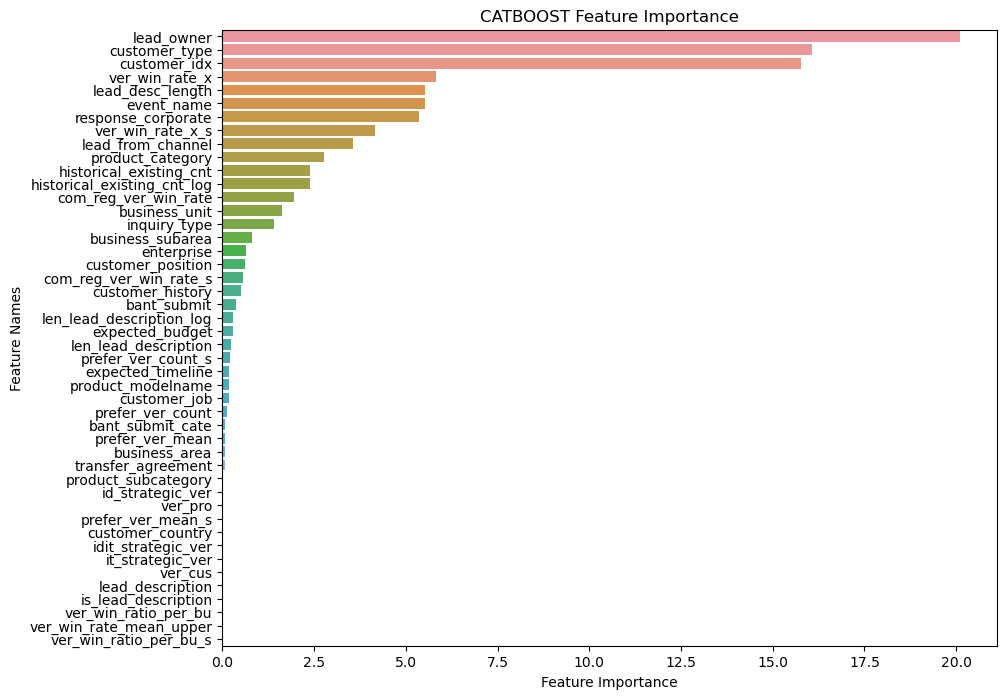

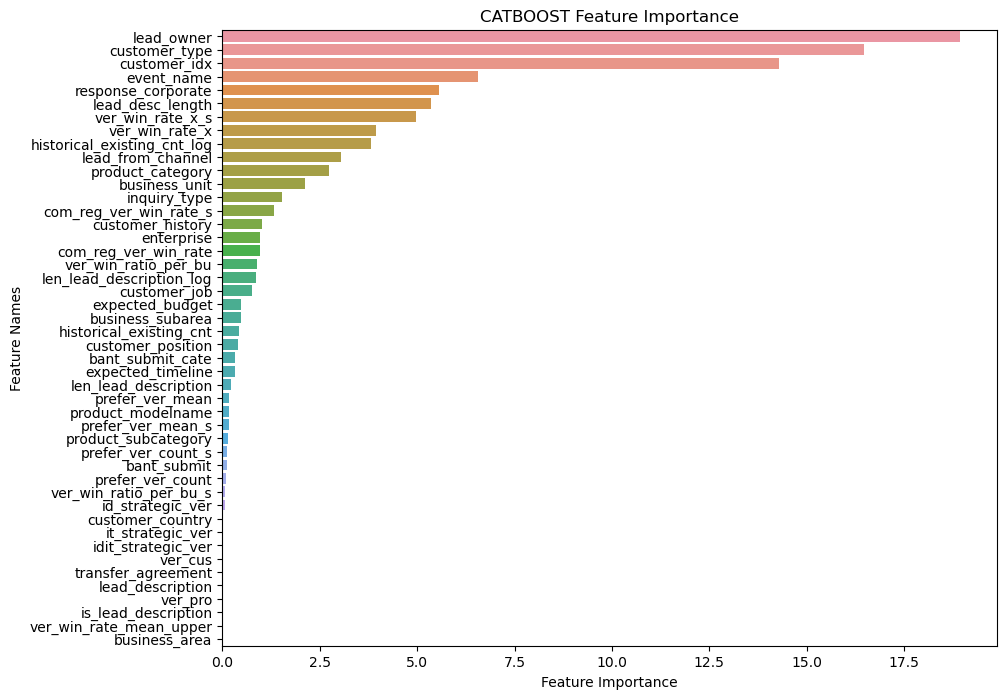

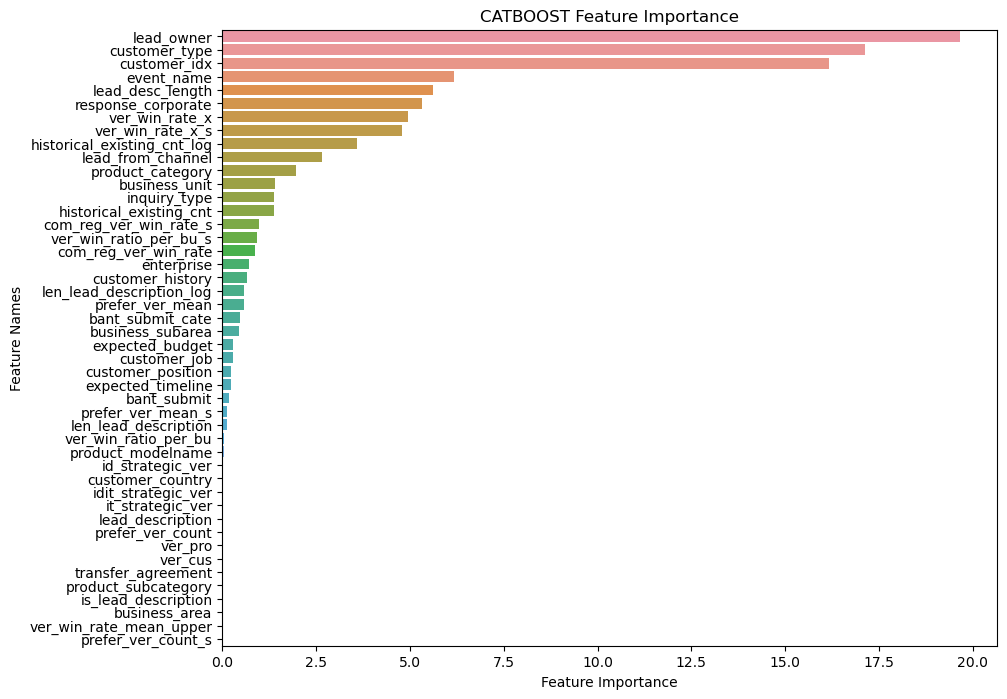

In [70]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
for i in best_models:
    plot_feature_importance(i.get_feature_importance(),df_test.drop(['is_converted','id'],axis=1).columns,'CATBOOST')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_feature_importance(importance,names,model_type):
    
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,8))

    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])

    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')

plot_feature_importance(best_models[0].get_feature_importance(),df_test.drop(['is_converted','id'],axis=1).columns,'CATBOOST')

In [16]:
sum(hard_pred)

1959